Setting up enviornment

In [ ]:
!pip install watermark
!pip install transformers #==2.8.0

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.33.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.11.0
transformers: 4.18.0



Imports and some global settings

In [3]:
# imports and global settings
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup, BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import defaultdict
from torch import nn
from torch.utils.data import Dataset, DataLoader


# settings for plotter
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# to remember if there is Positive/Negative sentiment analysis with/without neutral sentiments
isNegativeFound = False
isNeutralFound = False
isPositiveFound = False
SENTIMENT_COUNTER = 0

In [4]:
RANDOM_SEED = 23052022
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
PRE_TRAINED_MODEL_NAME = 'EMBEDDIA/sloberta'
# PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
# PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'


TOKENIZER = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) # BertTokenizer
BERT_MODEL = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False) # BertModel    # return_dict=False for transformer >= 4.x

Downloading:   0%|          | 0.00/506 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/781k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/298 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/520 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertModel were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to us

In [6]:
# # shows device that it will be using
# DEVICE

In [7]:
# # Double check that you are using GPU
# # to see what kind of hardware will be used
# !nvidia-smi

In [8]:
BATCH_SIZE = 16

Functions and class used

In [9]:
# functions to prepare inputed corpus

def to_sentiment_from_text(sentiment):
    global SENTIMENT_COUNTER, isPositiveFound, isNeutralFound, isNegativeFound
    if sentiment == 'neg':
        if isNegativeFound is False:
            SENTIMENT_COUNTER += 1
            isNegativeFound = True
        return 0
    elif sentiment == 'neu':
        if isNeutralFound is False:
            SENTIMENT_COUNTER += 1
            isNeutralFound = True
        return 1
    elif sentiment == 'pos':
        if isPositiveFound is False:
            SENTIMENT_COUNTER += 1
            isPositiveFound = True
        return 2


def to_sentiment_from_number(rating):
    global SENTIMENT_COUNTER, isPositiveFound, isNeutralFound, isNegativeFound
    rating = int(rating)

    if rating <= 2:
        if isNegativeFound is False:
          SENTIMENT_COUNTER += 1
          isNegativeFound = True
        return 0
    elif rating == 3:
        if isNeutralFound is False:
            SENTIMENT_COUNTER += 1
            isNeutralFound = True
        return 1
    else: 
        if isPositiveFound is False:
            SENTIMENT_COUNTER += 1
            isPositiveFound = True
        return 2


def analyse_corpus_content(tokenizer, csv_like_file, text_column_name: str):
    token_lens = []

    for txt in csv_like_file[text_column_name]:
        tokens = tokenizer.encode(txt, max_length=512)
        token_lens.append(len(tokens))

    sns.distplot(token_lens)
    plt.xlim([0, 256]) # 256 or 512 for input with long "words"
    plt.xlabel('Token count')
    # exit(55)


class GPReviewDataset(Dataset):
    def __init__(self, text, targets, tokenizer, max_len, text_column_name: str):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_column_name = text_column_name

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


def create_data_loader(csv_like_file, text_column_name: str, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        text=csv_like_file[text_column_name].to_numpy(),
        # targets=csv_like_file.sentiment.to_numpy(),
        targets=np.nan_to_num(csv_like_file.sentiment.to_numpy(), copy=True, nan=2, posinf=None, neginf=None),
        tokenizer=tokenizer,
        max_len=max_len,
        text_column_name=text_column_name
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True,
        # num_workers=4       # uses ?CPU? workers for loading data onto RAM, in windows might cause problems
    )

In [10]:
# BERT base

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BERT_MODEL
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        output = self.drop(pooled_output)
        return self.out(output)

In [11]:
# BERT training, evaluation and predictions

def train_epoch(
        passed_model,
        data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        n_examples
):
    passed_model = passed_model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = passed_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(passed_model, data_loader, loss_fn, device, n_examples):
    passed_model = passed_model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = passed_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


def get_predictions(pass_model, data_loader):
    pass_model = pass_model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(DEVICE)
            attention_mask = d["attention_mask"].to(DEVICE)
            targets = d["targets"].to(DEVICE)

            outputs = pass_model(
                input_ids=input_ids,
                attention_mask=attention_mask

            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values


Uploading files to current directory




In [12]:
# import os
# print(os.getcwd())

In [ ]:
# to download files from google drive
!pip install gdown

In [ ]:
# download training data

# !gdown --id ID_STRING    if public, you can use this one
# !gdown --id 1DVrIDFsYEkeeOC8lbctI2bMYCcx61cf0 # complete_corpus_extended.csv

## alternitive ways to download
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OQeQQzaXxQqrSyEvJ8snoLNBXIsA8kph' -O complete_training_corpus.csv
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1eF8AUsQReZ8RCN0ipoBTYkwBNIwIfV7S' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=complete_training_corpus_long.csv" -O complete_training_corpus_long.csv && rm -rf /tmp/cookies.txt
# !git clone "url"

Main parts of program


In [15]:
# loads data

corpus = pd.read_csv("your_corpus_name.csv", sep="\t")  # delimiter might be redundent in your case
corpus['sentiment'] = corpus.sentiment.apply(to_sentiment_from_text)

In [16]:
# generates array with sentiments name based on input
class_names = []

if isNegativeFound is True:
    class_names.append('negative')
if isNeutralFound is True:
    class_names.append('neutral')
if isPositiveFound is True:
    class_names.append('positive')

Show what is inside file

In [17]:
# corpus.info()

Show how much balanced are data

In [18]:
# ax = sns.countplot(corpus.sentiment)
# plt.xlabel('sentiment')
# ax.set_xticklabels(class_names);

Balance of complete_corpus_extended.csv

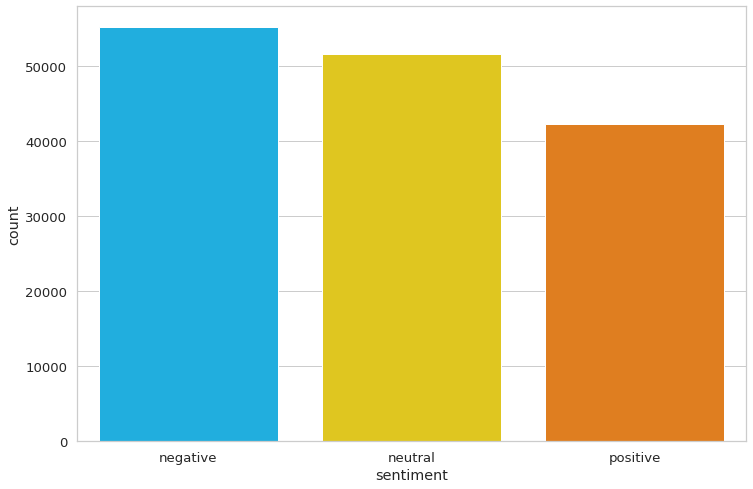

Balance of complete_training_corpus_long.csv

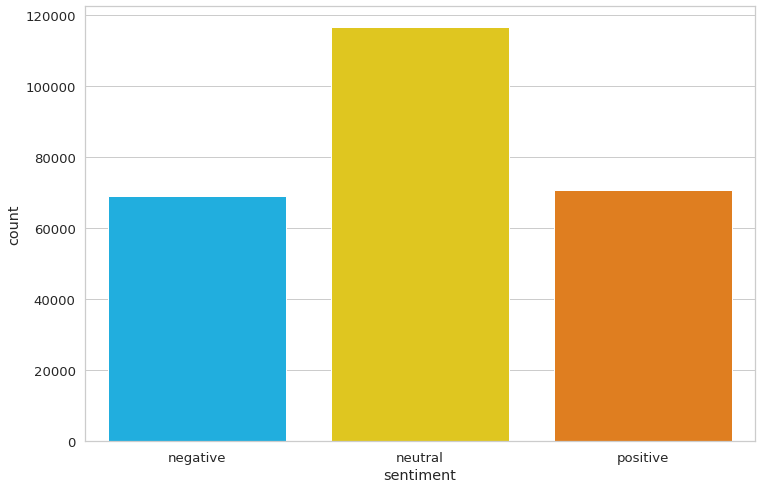

Help determine MAX_LEN

In [19]:
# # to check what size you should use for MAX_LEN of DataLoader, correct in the first few lines of code
# # !! IMPORTANT !!words
# analyse_corpus_content(TOKENIZER, corpus, 'words')

Picture of token decenty of complete_training_corpus_extended.csv

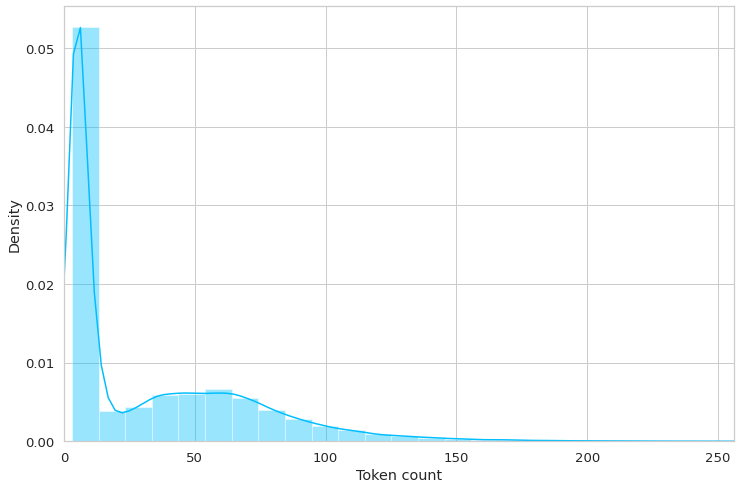

In this case we will be using MAX_LEN of 190



Picture of token decenty of complete_training_corpus_long.csv

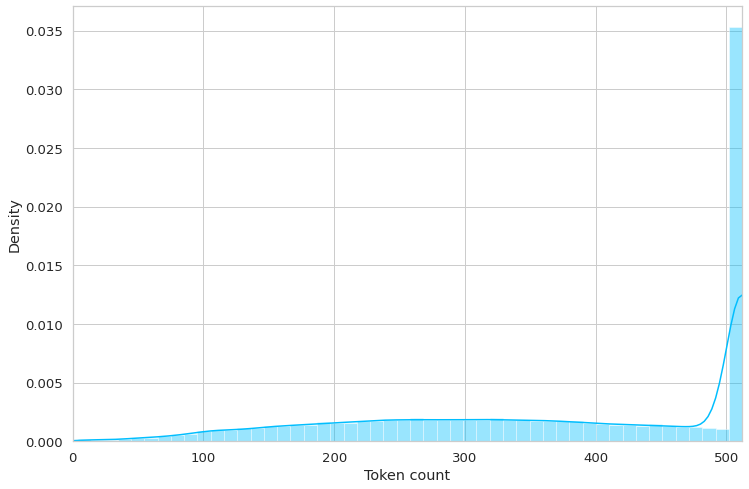

In case of "complete_training_corpus_long.csv" we will be using maximum (512)

In [20]:
MAX_LEN = 190  # lenght of sequence of tokens in "line" for BERT (test with analyse_corpus_content(...) to see what suits your data set the best)

In [21]:
# prepare data for DataLoader

corpus_train, corpus_test = train_test_split(
    corpus,
    test_size=0.1,
    random_state=RANDOM_SEED
)

corpus_val, corpus_test = train_test_split(
    corpus_test,
    test_size=0.5,
    random_state=RANDOM_SEED
)

train_data_loader = create_data_loader(corpus_train, 'words', TOKENIZER, MAX_LEN, BATCH_SIZE)
valid_data_loader = create_data_loader(corpus_val, 'words', TOKENIZER, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(corpus_test, 'words', TOKENIZER, MAX_LEN, BATCH_SIZE)

In [22]:
# # initialize BERT model

# model = SentimentClassifier(SENTIMENT_COUNTER)
# model = model.to(DEVICE)

In [ ]:
# download your pretrain bert model
!gdown --id ID
#!gdown --id 1zG_PvYwcSWGNC_SeE6bJDd2dQB7BQjwo   # final version, with 8 epoch of training

model = SentimentClassifier(3)   # number of sentiment classes (negative, neutral, positive)
model.load_state_dict(torch.load('your_bert_model_name.bin'))
model = model.to(DEVICE)

In [24]:
EPOCHS = 3   # keep in mind how much time one epoch takes (~ 50min)

In [25]:
# train based on input

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(DEVICE)

history = defaultdict(list)
best_accuracy = 0

# %%time
# start_total_time = time.time()


for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # tic = time.time()

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        DEVICE,
        scheduler,
        len(corpus_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        valid_data_loader,
        loss_fn,
        DEVICE,
        len(corpus_val)
    )

    # toc = round(tic - time.time())
    # m, s = divmod(toc, 60)

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    # print(f'\nTime taken: {m:02d}m {s:02d}s') 
    print('')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # save model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'bert_normal_model_final.bin')
        best_accuracy = val_acc


# end_total_time = round(start_total_time - time.time())
# m, s = divmod(end_total_time, 60)
# h, m = divmod(m, 60)

# print(f'\n\nTotal time taken: {h:d}h {m:02d}m {s:02d}s')

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a ma

Epoch 1/3
----------
Train loss 0.5362474706321422 accuracy 0.7751761848711951
Val   loss 0.4957835981722052 accuracy 0.7890572616333646

Epoch 2/3
----------
Train loss 0.42223435172120705 accuracy 0.8313542023630377
Val   loss 0.4581815204812449 accuracy 0.8184256403379375

Epoch 3/3
----------
Train loss 0.360586203666486 accuracy 0.8602738501422889
Val   loss 0.463916312927097 accuracy 0.8221805015421753



In [26]:
# show statistics of training based on test part of corpus

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

# shows statistics
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.86      0.83      0.85      2740
     neutral       0.74      0.79      0.76      2530
    positive       0.88      0.84      0.86      2188

    accuracy                           0.82      7458
   macro avg       0.83      0.82      0.82      7458
weighted avg       0.83      0.82      0.82      7458

